In [131]:
import numpy as np
from pymatching import Matching
from collections import Counter
from qecsim import paulitools as pt
from qecsim.models.rotatedplanar import RotatedPlanarCode
import pandas as pd

class Ensemble():
    def __init__(self, num_decoders, code_size, t, rng=None):
        if rng is None:
            rng = np.random.default_rng()
        
        self.num_decoders = num_decoders
        self.code = RotatedPlanarCode(code_size, code_size)
        self.rng = rng
        
        parity_check_matrix = self.code.stabilizers
        self.H_x = parity_check_matrix[parity_check_matrix.shape[0]//2:][:, :parity_check_matrix.shape[1]//2]
        self.H_z = parity_check_matrix[:parity_check_matrix.shape[0]//2][:, parity_check_matrix.shape[1]//2:]
        self.decoders = self._generate_decoder_ensemble(t)
        
    def _generate_decoder_ensemble(self, t):      
        # Initialize an empty list to store the decoders
        ensemble = []
        # Create the ensemble of decoders
        for _ in range(self.num_decoders):
            # Generate random weights for the decoder
            T1 = self.rng.uniform(0, 100, size=self.H_x.shape[1])*1e-6
            T2 = self.rng.uniform(0, 100, size=self.H_z.shape[1])*1e-6
            weights_x = np.abs(np.log(1-np.exp(-t/np.array(T1))))
            weights_z = np.abs(np.log(1-np.exp(-t/np.array(T2))))

            # Initialize the decoder with the random weights
            decoder_x = Matching(self.H_x, weights_x)
            decoder_z = Matching(self.H_z, weights_z) 

            # Add the decoder to the ensemble
            ensemble.append((decoder_x, decoder_z))
        return ensemble
    
    def add_decoder(self, weights_x=None, weights_z=None):
        decoder_x = Matching(self.H_x, weights_x)
        decoder_z = Matching(self.H_z, weights_z)
        self.decoders.append((decoder_x, decoder_z))
        
    def get_weights(self, decoder):
        # get x weights
        weights_x = []
        for edge in self.decoders[decoder][0].edges():
            weights_x.append(edge[-1]["weight"])
        # get z weights
        weights_z = []
        for edge in self.decoders[decoder][1].edges():
            weights_z.append(edge[-1]["weight"])
        return weights_x, weights_z
        
    
    def decode(self, errors):      
        errors_x, errors_z = np.hsplit(np.array(errors), 2)
        syndromes_x = [self.H_x @ error % 2 for error in errors_x]
        syndromes_z = [self.H_z @ error % 2 for error in errors_z]
        
        data = []
        for (d_x, d_z) in self.decoders:
            # Initialize an empty list to store the decoded errors
            recoveries_x = d_x.decode_batch(syndromes_x)
            recoveries_z = d_z.decode_batch(syndromes_z)
            recoveries = np.concatenate((recoveries_x, recoveries_z), axis=1)
            data.append(recoveries)
            
        recovery_strings = np.nan * np.ones((len(self.decoders), len(errors)), dtype=object)
        for d in range(len(self.decoders)):
            for e in range(len(errors)):
                recovery_strings[d][e] = pt.bsf_to_pauli(data[d][e])

        df_data = []
        for e in range(len(errors)):
            recovery_counts = Counter(recovery_strings[:, e])
            majority_recovery_str, majority_count = recovery_counts.most_common(1)[0]
            majority_recovery = pt.pauli_to_bsf(majority_recovery_str)
            majority_success = not (any(pt.bsp(majority_recovery ^ errors[e], self.code.stabilizers.T)) or any(pt.bsp(majority_recovery ^ errors[e], self.code.logicals.T)))
            for d in range(len(self.decoders)):
                success = not (any(pt.bsp(data[d][e] ^ errors[e], self.code.stabilizers.T)) or any(pt.bsp(data[d][e] ^ errors[e], self.code.logicals.T)))
                df_data.append({'error': e, 'decoder': d, 'recovery': data[d][e], "success": success, "majority_recovery": majority_recovery, 'majority_count': majority_count, "majority_sucess": majority_success, 'is_majority': np.array_equal(data[d][e], majority_recovery)})
        return pd.DataFrame(df_data)


In [132]:
from qecsim.models.generic import INIDErrorModel
from qecsim.models.rotatedplanar import RotatedPlanarCode

NUM_DECODERS = int(20) # number of decoders in the ensemble
SIZE = 5 # size of the code
T = 1e-6 # time related to error rate

# T_1 and T_2 data from ibm_sherbrooke 11.03.2024 
T_1 = [4.47131398e-04, 2.26458412e-04, 2.92798247e-04, 2.90948197e-04, 3.40581391e-04, 2.83836831e-04, 2.70656858e-04, 1.53601864e-04, 3.61852447e-04, 2.42139994e-04, 2.00143049e-04, 3.61774782e-04, 2.45283244e-04, 3.47100922e-04, 2.93481282e-04, 4.21930409e-04, 2.52775994e-04, 2.77442387e-04, 2.46129903e-04, 3.78459014e-04, 2.45232302e-04, 2.96744679e-04, 1.78567010e-04, 3.93160649e-04, 3.59094685e-04, 2.86956081e-04, 3.45384767e-04, 3.86961497e-04, 2.05691776e-04, 4.28754692e-04, 3.74780068e-04, 2.88966813e-04, 2.47889883e-04, 3.86880708e-04, 1.24536308e-04, 2.62453326e-04, 9.64438829e-05, 2.64377947e-04, 1.28466986e-04, 1.31691725e-04, 4.36206180e-04, 2.22960692e-04, 4.25424927e-04, 3.95216491e-04, 2.28763892e-04, 4.03873696e-04, 2.71036498e-04, 3.23739417e-04, 3.55001763e-04, 4.63425047e-05, 2.94978244e-04, 2.28271419e-04, 4.06929723e-04, 2.56146538e-04, 1.72188791e-04, 1.73462107e-04, 2.74696491e-04, 2.30326227e-04, 3.00553262e-04, 2.27812102e-04, 2.89711877e-04, 2.59015813e-04, 1.16374746e-04, 2.10523923e-04, 3.21825423e-04, 2.52531191e-04, 3.50659516e-04, 3.59079952e-04, 2.68641573e-04, 2.33773519e-04, 2.97749853e-04, 2.08399114e-04, 2.43029285e-04, 2.85902283e-04, 2.84630852e-04, 3.55945256e-04, 2.97832844e-04, 2.36402484e-04, 2.49531082e-04, 1.33130091e-04, 2.19092374e-04, 2.40286350e-04, 3.34206274e-04, 3.67597836e-04, 2.55269321e-04, 2.47502383e-04, 2.61491269e-04, 2.02710898e-04, 2.40839962e-04, 3.28335949e-04, 2.54947652e-04, 1.86721803e-04, 4.09207513e-04, 3.30273185e-04, 2.61297556e-04, 2.64197469e-04, 1.26940583e-04, 2.75063562e-04, 2.02244248e-04, 3.59510470e-04, 1.84129054e-04, 2.68350896e-04, 2.43577740e-04, 2.18748598e-04, 5.43395245e-05, 3.00174758e-04, 1.12444264e-04, 2.96240040e-04, 2.45289428e-04, 1.33545326e-04, 3.30455266e-04, 1.86542047e-04, 1.80401351e-04, 3.43144232e-04, 2.29711485e-04, 2.86391366e-04, 1.98113525e-04, 2.63177780e-04, 3.06908883e-04, 3.28242820e-04, 1.92885813e-04, 1.40990586e-04, 7.05505794e-05, 2.17445019e-04, 3.10653668e-04]    
T_2 = [2.63153399e-04, 2.86761491e-04, 1.41151669e-04, 1.66627797e-04, 1.89576638e-04, 2.92269093e-04, 2.25063209e-04, 1.81702907e-04, 2.61984119e-04, 6.11325611e-05, 1.51575773e-04, 7.41630478e-05, 2.20899934e-04, 1.02816518e-04, 5.27691939e-05, 1.76258452e-04, 7.50720939e-05, 7.53161361e-05, 5.95427485e-05, 4.67441780e-05, 6.18971486e-05, 2.34925562e-05, 2.04210901e-04, 2.20918687e-04, 1.13223403e-04, 4.50195613e-04, 2.14757890e-04, 1.48510585e-04, 7.82218006e-05, 1.92858061e-04, 2.79777668e-04, 3.21622414e-05, 1.26789703e-04, 2.57254131e-04, 1.03558923e-04, 5.48399307e-05, 4.24278864e-05, 3.44606876e-04, 6.01732031e-05, 6.37432976e-05, 2.06647237e-04, 3.28893299e-04, 3.36020790e-04, 2.55291187e-04, 2.83855122e-04, 3.11659323e-04, 3.16825279e-04, 1.20567129e-04, 3.31208982e-04, 7.45987011e-05, 1.50608995e-04, 7.74456392e-05, 2.81359658e-04, 5.08315903e-05, 2.03901246e-04, 1.69324501e-05, 6.82253376e-05, 1.20970691e-04, 2.80741944e-04, 2.62828664e-04, 2.86550495e-04, 2.31743470e-04, 8.82750115e-05, 1.96014297e-04, 2.98465911e-04, 6.06746939e-05, 2.26737507e-04, 6.31369444e-05, 1.86726857e-05, 2.47944963e-04, 1.26382882e-04, 2.54025918e-04, 1.78993791e-04, 1.91150516e-04, 1.79769739e-04, 8.40042940e-05, 1.70200659e-04, 3.51177500e-04, 2.96748335e-05, 1.39399172e-04, 1.90544238e-04, 2.02677259e-04, 4.09724041e-05, 3.11031137e-04, 1.01932181e-04, 1.07444847e-04, 3.08357110e-04, 1.29828189e-04, 5.47172067e-05, 2.86959303e-04, 1.45406519e-04, 1.04390303e-04, 2.40856220e-05, 2.90835503e-04, 1.36119607e-04, 1.35983968e-04, 1.85294934e-04, 2.28204312e-04, 5.14639823e-05, 3.78015232e-04, 7.73972055e-05, 1.87827250e-04, 2.29362850e-04, 2.91204961e-04, 4.20846188e-05, 1.85991695e-04, 1.24689673e-04, 2.96066649e-04, 1.72330249e-04, 2.51645808e-04, 4.66399761e-05, 6.16320063e-05, 2.21848271e-04, 2.79667140e-04, 3.75513828e-04, 2.10413362e-04, 2.57497350e-04, 2.07386123e-04, 3.13663945e-04, 3.62394113e-05, 3.18518580e-04, 1.79348759e-04, 1.40142464e-04, 2.65291418e-05, 8.90078292e-05]


rng = np.random.default_rng(1)
ensemble = Ensemble(NUM_DECODERS, SIZE, T, rng)

# add two reference decoders with weights according to the T_1 and T_2 data and a decoder with all weights set to 1
optimal_weights = (np.abs(np.log(1-np.exp(-T/np.array(T_1))))[0:SIZE**2], np.abs(np.log(1-np.exp(-T/np.array(T_2))))[0:SIZE**2])
ensemble.add_decoder(*optimal_weights)
ensemble.add_decoder()


In [133]:
NUM_ERRORS = int(1e5) # number of errors to generate
rng_errors = np.random.default_rng(2)
error_model = INIDErrorModel(T_1, T_2)
errors = [error_model.generate(RotatedPlanarCode(SIZE, SIZE), T, rng_errors) for _ in range(NUM_ERRORS)]

In [134]:
df = ensemble.decode(errors)

In [135]:
print("sucess rate of majority recovery: ", df['majority_sucess'].mean())
print("sucess rate of optimal recovery: ", df[df['decoder'] == NUM_DECODERS]['success'].mean())

sucess rate of majority recovery:  0.97536
sucess rate of optimal recovery:  0.97622


<Axes: xlabel='decoder', ylabel='is_majority'>

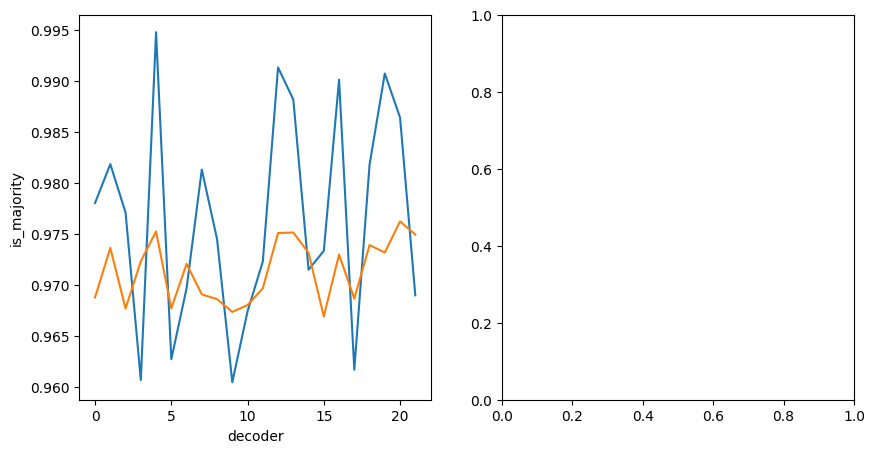

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10,5))

sns.lineplot(df.groupby('decoder')['is_majority'].mean(), ax=ax[0])
sns.lineplot(df.groupby('decoder')['success'].mean(), ax=ax[0])

In [137]:
# optimize the weights of one decoder
from scipy.optimize import minimize

NUM_ERRORS = int(1e3) # number of errors to generate
rng_errors = np.random.default_rng()
error_model = INIDErrorModel(T_1, T_2)
errors = [error_model.generate(RotatedPlanarCode(SIZE, SIZE), T, rng_errors) for _ in range(NUM_ERRORS)]

def optimize_weights(weights, errors):
    ensemble = Ensemble(0, 5, t=1e-5, rng=np.random.default_rng(1))
    weights_x, weights_z = np.split(weights, 2)
    ensemble.add_decoder(weights_x, weights_z)
    df = ensemble.decode(errors)
    return -df['success'].mean()

weights = np.zeros(2*SIZE**2)

print("success rate before optimization: ", abs(optimize_weights(weights, errors)))

result = minimize(optimize_weights, weights, args=(errors), method='Nelder-Mead', bounds=[(0, 5)]*(2*SIZE**2))

print("success rate after optimization: ", abs(optimize_weights(result.x, errors)))
print("optmial success rate: ", abs(optimize_weights(np.concatenate(optimal_weights), errors)))

success rate before optimization:  0.977
success rate after optimization:  0.982
optmial success rate:  0.98


In [138]:
print(result.x)


[5.624320e-06 5.624320e-06 5.624320e-06 5.624320e-06 5.624320e-06
 5.624320e-06 5.624320e-06 0.000000e+00 5.624320e-06 5.624320e-06
 5.624320e-06 5.624320e-06 5.624320e-06 5.624320e-06 5.624320e-06
 5.624320e-06 5.624320e-06 5.624320e-06 5.624320e-06 5.624320e-06
 6.812432e-05 5.624320e-06 5.624320e-06 5.624320e-06 5.624320e-06
 5.624320e-06 5.624320e-06 5.624320e-06 5.624320e-06 5.624320e-06
 5.624320e-06 5.624320e-06 5.624320e-06 5.624320e-06 6.812432e-05
 5.624320e-06 5.624320e-06 5.624320e-06 5.624320e-06 5.624320e-06
 5.624320e-06 5.624320e-06 5.624320e-06 4.080000e-07 5.624320e-06
 2.080000e-07 0.000000e+00 5.624320e-06 5.624320e-06 5.624320e-06]


In [139]:
NUM_ERRORS = int(1e3) # number of errors to generate
rng_errors = np.random.default_rng()
error_model = INIDErrorModel(T_1, T_2)
errors = [error_model.generate(RotatedPlanarCode(SIZE, SIZE), T, rng_errors) for _ in range(NUM_ERRORS)]

print("success rate optimal weights: ", abs(optimize_weights(np.concatenate(optimal_weights), errors)))
print("success rate after optimization: ", abs(optimize_weights(result.x, errors)))
print("success rate all weights 1: ", abs(optimize_weights(np.ones(2*SIZE**2), errors)))

success rate optimal weights:  0.974
success rate after optimization:  0.971
success rate all weights 1:  0.97
